# Microsoft Movie Data Analysis
## Problem Overview
The purpose of this EDA is to determine the types or genres of movies that are most in demand and are performing best in the market in order to come up with actionable insights for the company's stake holders.

## Business Understanding

Big companies have been recently flooding into the home entertainment industry of which movies are a big part. In this analysis we are going to look at data from sources such as IMDB the popular movie review site. We are looking to determine:
* Trend in how much movies gross over the years
* Most popular genres of movies
* Which genres gross the most domestically
* Which genres gross the most worldwide
* Trend in movie ratings over time

## Data Understanding

The first thing we shall do is import the necessary libraries and store our data in some pandas dataframes. From there we can use some descriptive methods to understand our data.

##### NB: The project directory contains a folder Data which contains the data files. Some files that are too large to push to github shall 
#####          be left compressed to be uncompressed when running this notebook

In [34]:
#modules for uncompressing some data files
import zipfile
import os

#path to compressed file
zip_file_imdb = 'Data/im.db.zip'

#path to extracted file
extracted_file_imdb = 'Data/im.db'

#check if extracted file already exists
if not os.path.isfile(extracted_file_imdb):
    #extract compressed file
    with zipfile.ZipFile(zip_file_imdb, 'r') as zip_reference:
        zip_reference.extractall('Data')

In [35]:
!cd Data && ls -a && cd ..

.			im.db		      rt.reviews.tsv.gz
..			im.db.zip	      tmdb.movies.csv.gz
bom.movie_gross.csv.gz	rt.movie_info.tsv.gz  tn.movie_budgets.csv.gz


In [36]:
import pandas as pd
import numpy as np
import sqlite3

#connection and cursor to database
conn = sqlite3.connect('Data/im.db')
cursor = conn.cursor()

Lets see what tables are in our ``im.db`` database.

In [37]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [38]:
movie_basics = pd.read_sql("SELECT * FROM movie_basics;", conn)
print("shape:", movie_basics.shape)
movie_basics.head()

shape: (146144, 6)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [39]:
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)
print("shape:", movie_ratings.shape)
movie_ratings.head(3)

shape: (73856, 3)


,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20


The cells above read necessary tables from the database into dataframes. 

In [40]:
movie_gross = pd.read_csv('Data/bom.movie_gross.csv.gz')
print("shape:", movie_gross.shape)
movie_gross.head(3)

shape: (3387, 5)


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010


In [41]:
movie_budgets = pd.read_csv('Data/tn.movie_budgets.csv.gz')
print("shape:", movie_budgets.shape)
movie_budgets.head(3)

shape: (5782, 6)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


Ok. We have our dataframes:
``movie_basics`` ``movie_gross``
``movie_ratings`` ``movie_budgets``

## Data Preparation
### Data Cleaning

#### 1.Lets normalize column names
This will make merging easier

In [42]:
movie_gross.rename(columns={'title':'primary_title'}, inplace=True)
movie_gross.columns

Index(['primary_title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [43]:
movie_budgets.rename(columns={'movie':'primary_title'}, inplace=True)
movie_budgets.columns

Index(['id', 'release_date', 'primary_title', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')

#### 2.Missing Values.

In [44]:
print("movie_basics nulls:\n", movie_basics.isna().sum().loc[movie_basics.isna().sum()>0])
print("movie_ratings nulls:\n", movie_ratings.isna().sum().loc[movie_ratings.isna().sum()>0])
print("movie_gross nulls:\n", movie_gross.isna().sum().loc[movie_gross.isna().sum()>0])
print("movie_budgets nulls:\n", movie_budgets.isna().sum().loc[movie_budgets.isna().sum()>0])

movie_basics nulls:
 original_title        21
runtime_minutes    31739
genres              5408
dtype: int64
movie_ratings nulls:
 Series([], dtype: int64)
movie_gross nulls:
 studio               5
domestic_gross      28
foreign_gross     1350
dtype: int64
movie_budgets nulls:
 Series([], dtype: int64)


In [45]:
#fill null values in 'runtime_minutes' column with the mean value
movie_basics['runtime_minutes'].fillna(movie_basics['runtime_minutes'].mean(), inplace=True)
#Remove all remaining rows with null values
movie_basics.dropna(axis=0, inplace=True)
movie_basics.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

For the ``movie_gross`` dataframe, we are going to create two subsets of the dataframe so that one contains only domestic movie grossing and the other contains foreign grossing with null values eliminated.

In [46]:
movie_domestic_gross =  movie_gross.loc[:, movie_gross.columns != 'foreign_gross']
movie_foreign_gross = movie_gross.loc[:, movie_gross.columns != 'domestic_gross']
print("domestic_null:\n", movie_domestic_gross.isna().sum(),"\nforeign_null:\n", movie_foreign_gross.isna().sum())

domestic_null:
 primary_title      0
studio             5
domestic_gross    28
year               0
dtype: int64 
foreign_null:
 primary_title       0
studio              5
foreign_gross    1350
year                0
dtype: int64


In [47]:
movie_domestic_gross.dropna(inplace=True)
movie_foreign_gross.dropna(inplace=True)
print("domestic:", movie_domestic_gross.shape)
print("foreign:", movie_foreign_gross.shape)

domestic: (3356, 4)
foreign: (2033, 4)


<ipython-input-47-50876856e023>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_domestic_gross.dropna(inplace=True)
<ipython-input-47-50876856e023>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_foreign_gross.dropna(inplace=True)


#### 3.Duplicates

In [48]:
print("movie_basics dups:\n", movie_basics.duplicated().sum())
print("movie_ratings dups:\n", movie_ratings.duplicated().sum())
print("movie_domestic_gross dups:\n", movie_domestic_gross.duplicated().sum())
print("movie_foreign_gross dups:\n", movie_foreign_gross.duplicated().sum())
print("movie_budgets dups:\n", movie_budgets.duplicated().sum())

movie_basics dups:
 0
movie_ratings dups:
 0
movie_domestic_gross dups:
 0
movie_foreign_gross dups:
 0
movie_budgets dups:
 0


#### 4.Outliers

In [49]:
movie_basics = movie_basics[movie_basics['runtime_minutes']<movie_basics['runtime_minutes'].quantile(0.99)]
movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.000000,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.000000,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,86.187247,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.000000,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.000000,Comedy
...,...,...,...,...,...,...
146138,tt9916428,The Secret of China,The Secret of China,2019,86.187247,"Adventure,History,War"
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.000000,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,86.187247,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,86.187247,Comedy


``movie_basics`` has the year column represented in an abnormal way. Lets clean that up.

In [50]:
movie_basics.rename(columns={'start_year':'year'}, inplace=True)
movie_basics.head()

,movie_id,primary_title,original_title,year,runtime_minutes,genres
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.000000,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.000000,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,86.187247,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.000000,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.000000,Comedy


Finally lets clean values in ``movie_budgets`` to contain integers and remove the '$' and ','

In [51]:
# Function that converts values in monetary terms to int.
def dollars_to_int(money_df):
    for column in money_df.columns:
#         print(type(column))
#Note ...dtype == 'object' checks if column contains strings
        if money_df[column].dtype == 'object' and money_df[column].values[0].startswith('$'):
            money_df[column] = money_df[column].str.replace('$', '').str.replace(',', '').astype(int)
dollars_to_int(movie_budgets)
movie_budgets.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


In [52]:
movie_df_names=[movie_basics, movie_ratings, movie_domestic_gross, movie_foreign_gross, movie_budgets]

In [53]:
# a function to print out head()'s in our dfs
def print_heads(df_names):
    for df in df_names:
        print(str(df.columns), "\n", df.head(2), "\n\n")
print_heads(movie_df_names)

Index(['movie_id', 'primary_title', 'original_title', 'year',
       'runtime_minutes', 'genres'],
      dtype='object') 
     movie_id                    primary_title              original_title  \
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   

   year  runtime_minutes           genres  
1  2019            114.0  Biography,Drama  
2  2018            122.0            Drama   


Index(['movie_id', 'averagerating', 'numvotes'], dtype='object') 
      movie_id  averagerating  numvotes
0  tt10356526            8.3        31
1  tt10384606            8.9       559 


Index(['primary_title', 'studio', 'domestic_gross', 'year'], dtype='object') 
                 primary_title studio  domestic_gross  year
0                 Toy Story 3     BV     415000000.0  2010
1  Alice in Wonderland (2010)     BV     334200000.0  2010 


Index(['primary_title', 'studio', 'foreign_gross', 'year'], dtyp

In [54]:
movie_basics.to_json('CleanData/clean_movie_basics.json')
movie_ratings.to_json('CleanData/clean_movie_ratings.json')
movie_domestic_gross.to_json('CleanData/clean_movie_domestic_gross.json')
movie_foreign_gross.to_json('CleanData/clean_movie_foreign_gross.json')
movie_budgets.to_json('CleanData/clean_movie_budgets.json')

In [55]:
!cd CleanData && ls -alh && cd ..

total 22M
drwxrwxr-x 2 josh josh 4.0K Mac 10 18:12 .
drwxrwxr-x 7 josh josh 4.0K Mac 12 08:44 ..
-rw-rw-r-- 1 josh josh  18M Mac 12 08:46 clean_movie_basics.json
-rw-rw-r-- 1 josh josh 577K Mac 12 08:46 clean_movie_budgets.json
-rw-rw-r-- 1 josh josh 221K Mac 12 08:46 clean_movie_domestic_gross.json
-rw-rw-r-- 1 josh josh 135K Mac 12 08:46 clean_movie_foreign_gross.json
-rw-rw-r-- 1 josh josh 3.1M Mac 12 08:46 clean_movie_ratings.json


The two cells above store our dataframes in clean files in a folder CleanData.

## Analysis

In [56]:
#import vis libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#reloading our dataset
movie_basics = pd.read_json('CleanData/clean_movie_basics.json')
movie_ratings = pd.read_json('CleanData/clean_movie_ratings.json')
movie_budgets = pd.read_json('CleanData/clean_movie_budgets.json')
movie_domestic_gross = pd.read_json('CleanData/clean_movie_domestic_gross.json')
movie_foreign_gross = pd.read_json('CleanData/clean_movie_foreign_gross.json')

#seaborn styles
sns.set_style('whitegrid')

### 1.Most common Genres

Lets plot a bar chart showing the top 10 most occuring genre of movies in our ``movie_basics`` df

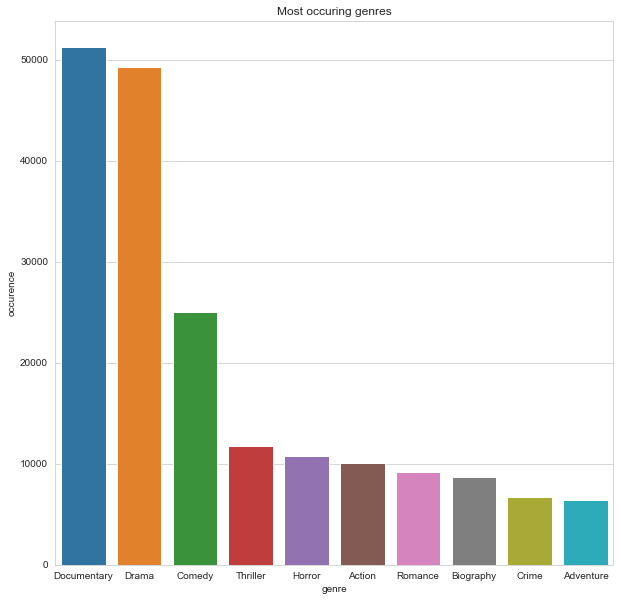

In [57]:

#figure and axes for top_10_genres_plot
top_10_genres_fig, top_10_genres_ax = plt.subplots(figsize=(10,10))

#loop to populate a list with unique genre names
genre_name_list = []

for current_movie_genres in movie_basics.genres:
    curr_mov_genre_list = current_movie_genres.split(',')
    for genre in curr_mov_genre_list:
        if genre in genre_name_list:
            continue;
        elif genre not in genre_name_list:
            genre_name_list.append(genre)
#Dict to store genre name and count
genre_counts_dict = {}
for genre in genre_name_list:
    genre_counts_dict[genre] = movie_basics[movie_basics['genres'].str.contains(genre)].shape[0]
genre_counts_df = pd.DataFrame.from_dict(dict(sorted(genre_counts_dict.items(),
                                                     key=lambda item:item[1],
                                                     reverse=True)), orient='index')
#plot
top_10_genres = genre_counts_df.reset_index().rename(columns={'index':'genre', 0:'occurence'})[:10]
top_10_genres_plot = sns.barplot(data=top_10_genres, x='genre', y='occurence', ax=top_10_genres_ax)
top_10_genre_names = list(top_10_genres.genre)
top_10_genres_ax.set_title('Most occuring genres')
top_10_genres_fig.savefig('./images/top_10_genres.png');

From the plot it seems most movies produced are classified as **Documentary**, **Drama** and some falling under **Comedy**. Althought there is a large disparity between the first two genres and the third.

### 2.Relationship between production cost and worldwide gross.

In [59]:
movie_budgets.head(10)

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,300000000,309420425,963420425
8,9,"Nov 17, 2017",Justice League,300000000,229024295,655945209
9,10,"Nov 6, 2015",Spectre,300000000,200074175,879620923


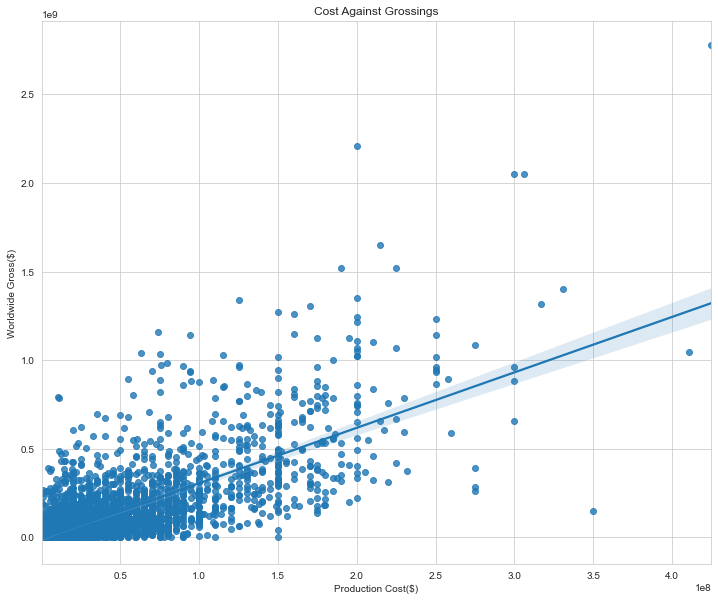

In [60]:
#scatterplot
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'], format='%b %d, %Y')
cost_gross_fig, cost_gross_ax = plt.subplots(figsize=(12,10))
sns.regplot(x=movie_budgets['production_budget'], y=movie_budgets['worldwide_gross'])
cost_gross_ax.set_title('Cost Against Grossings')
cost_gross_ax.set_xlabel('Production Cost($)')
cost_gross_ax.set_ylabel('Worldwide Gross($)')
cost_gross_fig.savefig('./images/cost_gross.png');

From the scatter plot above, we can tell clearly using the regression line that a relationship exists between the **production_cost** of a movie and its **grossing**

### 3.Trend in movie ratings over time per genre

A lineplot showing how movie ratings have changed over the year. This can be useful in understanding consumer reception.

In [63]:
#df to store merged basic and rating dataframes
basics_and_ratings = pd.merge(movie_basics, movie_ratings, on='movie_id', how='right').dropna()
basics_and_ratings.tail()

,movie_id,primary_title,original_title,year,runtime_minutes,genres,averagerating,numvotes
73851,tt9805820,Caisa,Caisa,2018.0,84.000000,Documentary,8.1,25
73852,tt9844256,Code Geass: Lelouch of the Rebellion - Glorifi...,Code Geass: Lelouch of the Rebellion Episode III,2018.0,120.000000,"Action,Animation,Sci-Fi",7.5,24
73853,tt9851050,Sisters,Sisters,2019.0,86.187247,"Action,Drama",4.7,14
73854,tt9886934,The Projectionist,The Projectionist,2019.0,81.000000,Documentary,7.0,5
73855,tt9894098,Sathru,Sathru,2019.0,129.000000,Thriller,6.3,128


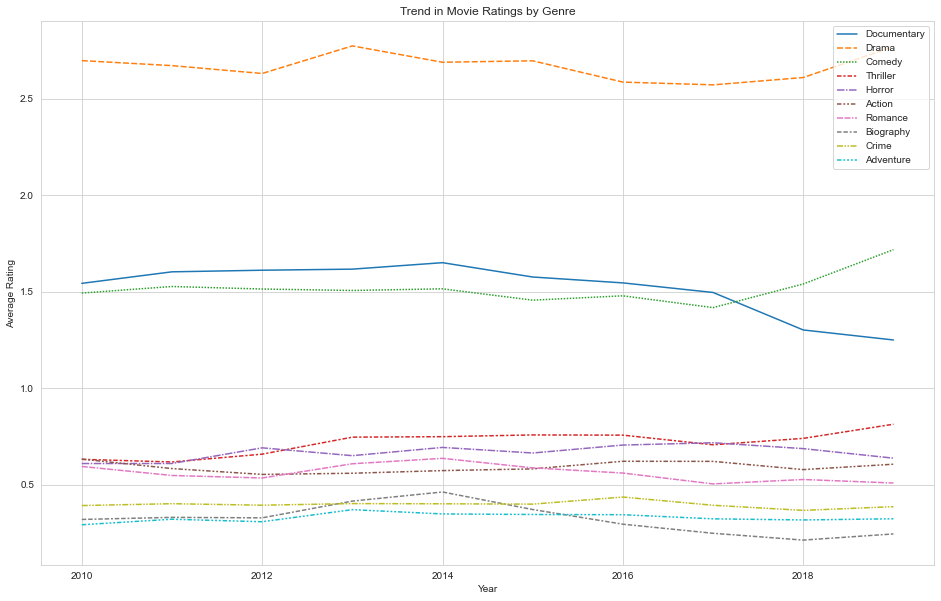

In [64]:
#get a df of binary indicators for genres per movie
genres_bin_df = basics_and_ratings['genres'].str.get_dummies(sep=',')
basics_ratings_genrewise = pd.concat([basics_and_ratings, genres_bin_df], axis=1)

#group by year and get mean rating per year 
basics_ratings_year_avg = basics_ratings_genrewise.groupby(['year']).mean()
#multiply avg binary values for each genre by the year average.
for genre in top_10_genre_names:
    basics_ratings_year_avg[genre] = basics_ratings_year_avg[genre] * basics_ratings_year_avg['averagerating']

#seaborn plot
rating_trend_fig, rating_trend_ax = plt.subplots(figsize=(16,10))

sns.lineplot(data=basics_ratings_year_avg[top_10_genre_names], ax=rating_trend_ax)
#plot details
rating_trend_ax.set_title('Trend in Movie Ratings by Genre')
rating_trend_ax.set_xlabel('Year')
rating_trend_ax.set_ylabel('Average Rating');
rating_trend_fig.savefig('./images/rating_trend.png');

From the plot we can decipher that of the top most common genres of movies, the **Documentaries** have been on a steady decline in ratings over the past 2-3 years. **Drama** seems to be maintaining high review scores. **Comedy** has been staedily increasing in ratings over the past few years surpasssing Documentaries in a ratings around 2017.

### 4.Relationship between runtime and rating

We can use a scatterplot to show the relationship between *runtime* and *rating* for all movies

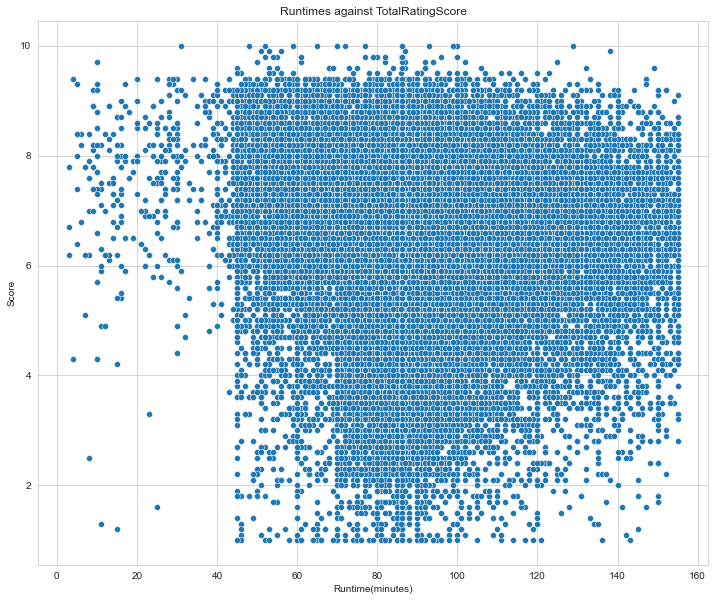

In [62]:
# Scatterplot
runtime_ratings_fig, runtime_ratings_ax = plt.subplots(figsize=(12,10))
basics_and_ratings['ratescore'] = basics_and_ratings['averagerating'] * basics_and_ratings['numvotes']
basics_and_ratings
sns.scatterplot(x=basics_and_ratings['runtime_minutes'], y=basics_and_ratings['averagerating'], ax=runtime_ratings_ax)
runtime_ratings_ax.set_title('Runtimes against TotalRatingScore')
runtime_ratings_ax.set_xlabel('Runtime(minutes)')
runtime_ratings_ax.set_ylabel('Score')
runtime_ratings_fig.savefig('./images/runtime_rating.png')
# plt.show();

There doesnt seem to be any clear relationship between runtime and rating.

### 5. Which genres gross the most 

In [65]:
#Above and Beyond
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## Summary

The most commonly produced genres of movies are:
* Documentary
* Drama
* Comedy

**Drama** ratings have maintained over the years. However **Documentary** Ratings have been declining in recent years. **Comedy** ratings have been on the steady incline, surpassing **documentaries**

The is a relationship between **production cost** of a movie and how much the movie **grosses**. It seems to be a positive covariant relationship.

## Conclusion.

-It would be advisable to Invest resources in one of the three most common genres. **Comedy** movies would be a good start as they are popular and seem to be on the rise in terms of ratings. **Drama** movies are good as a less risky investment as they seem to maintain their ratings. They are also rated significantly higher than most other genres. The production cost seems to be a good indicatior of the movies potential success.

## Next Steps

Further analysisi would be helpful in determining:
* cost per genre to produce
* most highly rated writers for each movie and each genre
etc.  
These are but a few of the extra steps that might be taken to get more insights.